In [1]:
import numpy as np
import pandas as pd
import pygmo as pg
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)

from sklearn.externals import joblib 
from config import MAX_DISCOUNT, FEATURES

%matplotlib inline
%load_ext line_profiler

In [2]:
df=pd.read_csv('training_data_randn.csv', nrows=100000)
print(len(df))

100000


In [3]:
cols_x = FEATURES
col_y = 'is_deal'
col_p = 'Probability'
print('Input features of the propensity model\n{}'.format(cols_x))

Input features of the propensity model
['Discount', 'RRP', 'Service', 'Elasticity', 'nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'x_c0', 'x_c1', 'CLV']


In [4]:
model = joblib.load('propensity_model_sklearn_mlp.pkl')

In [5]:
%%timeit
model.predict_proba(df[cols_x])[:, 1]

74.7 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Single-objective optimization

## User Defined Problem (UDP)

Let's try to find out the discount amount for each product in order to maximize our profit.

\begin{equation*}
Profit = RRP - Discount - Cost
\end{equation*}

First let's create our problem class:

In [ ]:
class optimal_discount_per_product_for_max_profit:
    def __init__(self, df, model): 
        self.cols_x = FEATURES
        self.df = df     
        self.model = model
        self.p_ids = df['product_id'].unique()
        self.p_ids.sort()
        self.n_products = len(self.p_ids)
        
    def fitness(self, dv): # fitness given decision vector (dv)
        prod_discount = dict(zip(self.p_ids, dv))
        v_discount = self.df['product_id'].map(prod_discount) * self.df['RRP']
        X = self.df[self.cols_x].values
        X[:, 0] = v_discount
        y_prob = self.model.predict_proba(X)[:, 1]
        profit = np.dot(self.df['RRP'] - v_discount - self.df['Cost'], y_prob)  
        return [-profit/1e6,]   # We want to maximize profit, hence set the (minimization) objective to minus profit

    def get_bounds(self): # box bounds of decision vector (dv)
        return ([0,]*self.n_products, [MAX_DISCOUNT, ]*self.n_products)

Notes:
* Mandatory methods you must implement: fitness(self, x) and get_bounds(self)
* PyGMO2 assume the problem is about minimization in every objective. Adapt your objectives accordingly.
* PyGMO2 by default treat the problem as single-objective, no constraint, no gradient, continuous decision vectors, etc.
* Return of fitness() must be a list, even for single-objective problems

In [ ]:
problem_profit = pg.problem(optimal_discount_per_product_for_max_profit(df, model))

## Population
Population is a collection of individual solutions that will be evoled according to some algorithm

In [ ]:
pop = pg.population(problem_profit, size=10)

In [ ]:
pop.get_x(), pop.get_f()

## Algorithm

For the single-objective problem, we use differential evolution (DE) as a first attempt. 

Full list of available algorithms and their applicability can be found at
https://esa.github.io/pagmo2/docs/algorithm_list.html

In [ ]:
algo = pg.algorithm(pg.de(gen = 100))
algo.set_verbosity(10) # Set interval of evolution for the algorithm to fill in logging information

In [ ]:
pop = algo.evolve(pop)

In [ ]:
best_x_rev = pop.champion_x
best_f_rev = pop.champion_f
print('Maximum profit £{:.1f}M to be achieved with discount rates:'.format(-best_f_rev[0])) 
for i,v in enumerate(best_x_rev):
    print('product {}:\t {:.1f}%'.format(i, 100*v))

In [ ]:
algo.extract(pg.de).get_log()

# Multi-objective optimization (MOO)

## Multi-objective problem (UDP)

In [6]:
class optimal_discount_per_product_for_max_revenue_min_cost:
    def __init__(self, df, model): 
        self.cols_x = FEATURES
        self.df = df
        self.p_ids = df['product_id'].unique()
        self.p_ids.sort()
        self.n_products = len(self.p_ids)
        self.model = model        
   
    def get_nobj(self):
        return 2
    
    def fitness(self, dv): # fitness given decision vector (dv)
        prod_discount = dict(zip(self.p_ids, dv))
        v_discount = self.df['product_id'].map(prod_discount) * self.df['RRP']
        X = self.df[self.cols_x].values
        X[:, 0] = v_discount
        y_prob = self.model.predict_proba(X)[:, 1]
        revenue = np.dot(self.df['RRP'] - v_discount, y_prob)  
        cost = np.dot(self.df['Cost'], y_prob)  
        return [-revenue/1e6,cost/1e6]   # Minimization objectives
    
    def get_bounds(self): # box bounds of decision vector (dv)       
        return ([0,]*self.n_products, [MAX_DISCOUNT, ]*self.n_products)

Notes:
* You need to explicitly indicate the problem as multi-objective with get_nobj(self)
* Minimize -revenue (i.e. maximize revenue) and minimize cost

In [7]:
problem_rev_cost = pg.problem(optimal_discount_per_product_for_max_revenue_min_cost(df, model))

## Population: Pareto frontiers and hypervolume

In [41]:
pop_init = pg.population(problem_rev_cost,size=32)

The ``fast_non_dominated_sorting()`` function process a list of objective tuples and return the sorted Pareto frontiers

In [42]:
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(pop_init.get_f())
ndf

[array([ 3,  5, 10, 12, 15, 20, 23, 25, 26, 27, 28], dtype=uint64),
 array([ 1, 11, 31, 13,  4,  7, 14,  9, 22,  6], dtype=uint64),
 array([16, 30, 29, 18, 19], dtype=uint64),
 array([ 8, 17, 21], dtype=uint64),
 array([24], dtype=uint64),
 array([0], dtype=uint64),
 array([2], dtype=uint64)]

* *ndf* (``list`` of 1D NumPy int array): the non dominated fronts. Each element is a list of indices in this frontier.
* *dl* (``list`` of 1D NumPy int array): the domination list. Each element is a list of indices dominated by this point.
* *dc* (1D NumPy int array): the domination count. Number of indices dominate this point.
* *ndr* (1D NumPy int array): the non domination ranks. The rank of the frontier this point belongs to.

In [43]:
def plot_revenue_cost_frontiers(fs, **kwarg):
    df = pd.DataFrame(fs, columns = ('Revenue', 'Cost')).sort_values('Revenue')   
    df.loc[:, 'pareto_group'] = pg.fast_non_dominated_sorting(df.values)[3]
    df['Revenue'] = -df['Revenue']
    df.groupby('pareto_group').plot('Revenue', 'Cost', style='o-', legend=False, **kwarg, ax=plt.gca())
    plt.gca().set_ylabel('Cost')
    return
   

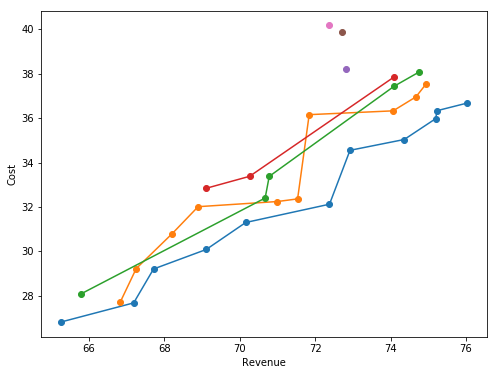

In [44]:
plot_revenue_cost_frontiers(pop_init.get_f(), figsize=(8,6)) 

**Hypervolume**
The quality measure for multi-objective optimization
* 2D: area between the Pareto frontier curve and a reference point
* 3D: volume between the Pareto frontier surface and a reference point
* 3+D: hypervolumn between the Pareto frontier hypersurface and a reference point

https://esa.github.io/pagmo2/docs/python/tutorials/hypervolume.html

In [45]:
refpoint = [-60, 60]
hv = pg.hypervolume(pop_init)
hv.compute(refpoint)

476.00834533260064

## Algorithm

Let's first try the NSGAII algorithm

https://esa.github.io/pagmo2/docs/python/algorithms/py_algorithms.html#pygmo.nsga2

In [ ]:
algo = pg.algorithm(pg.nsga2(gen = 256))

In [ ]:
pop = algo.evolve(pop_init)

In [ ]:
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(pop.get_f())
ndf

In [ ]:
hv = pg.hypervolume(pop)
hv.compute(refpoint)

## The optimized solutions

In [ ]:
fits, vectors = pop.get_f(), pop.get_x()
idx_sorted = fits.argsort(0)[:, 0]
df_solutions = pd.DataFrame(vectors[idx_sorted].round(2), columns=['Discount_%d'%i for i in range(5)])
df_solutions.loc[:, 'Revenue'] = -fits[idx_sorted, 0]
df_solutions.loc[:, 'Cost'] = fits[idx_sorted, 1]
df_solutions

In [ ]:
plot_revenue_cost_frontiers(pop.get_f(), figsize=(8,6)) 

## A little more logging

We can reduce the number of generations but repeat the call of ``evolve()`` multiple times, and monitor the progress over evolutions.

In [ ]:
n_gen = 512
algo = pg.algorithm(pg.nsga2(gen = 1))  # One generation for each call of algo.evolve()
pop = pg.population(problem_rev_cost,size=32)  # re-initialize
hv = pg.hypervolume(pop).compute(refpoint)
log_pop = []
log_pop.append((pop.get_x(), pop.get_f(), hv))
print(0, hv)
for i in range(n_gen):
    pop = algo.evolve(pop)
    hv = pg.hypervolume(pop).compute(refpoint)
    log_pop.append((pop.get_x(), pop.get_f(), hv))
    if np.log2(i+1).is_integer():
        print(i+1, hv)


In [ ]:
x_max = np.array([p[1] for p in log_pop])[:,:, 0].max()+1
x_min = np.array([p[1] for p in log_pop])[:,:, 0].min()-1
y_max = np.array([p[1] for p in log_pop])[:,:, 1].max()+1
y_min = np.array([p[1] for p in log_pop])[:,:, 1].min()-1
axis_range = ((x_min, x_max), (y_min, y_max))
for i, (dvs, fs, hv) in enumerate(log_pop):
    if np.log2(i+1).is_integer():
        plt.cla()
        ax = plot_revenue_cost_frontiers(fs, xlim=(-x_max, -x_min), ylim=(y_min, y_max), figsize=(8,6), title='Evolution %d'%(i+1)) 
        plt.savefig('test_%d.png'%(np.log2(i+1)))


# Parallelization

## Island

Unit parallelization block. Contains:
* A problem
* A population
* An algorithm    

Type of islands:
* Multi-threading
* Multi-processing
* Ipyparallel



In [9]:
def create_nsga2_island(cr, m):
    return pg.island(algo = pg.nsga2(gen = 20, cr=cr, m=m), 
                     prob = optimal_discount_per_product_for_max_revenue_min_cost(df, model), 
                     size=32)

islands_conf = [(cr, m) for cr in np.linspace(0.65, 0.95, 4) for m in np.logspace(-2, -1, 3)]
islands = [create_nsga2_island(*conf) for conf in islands_conf]

In [ ]:
_ = [isl.evolve() for isl in islands]

In [ ]:
_ = [isl.wait() for isl in islands]

In [ ]:
for i,isl in enumerate(islands):
    pop = isl.get_population()
    plot_revenue_cost_frontiers(pop.get_f(), figsize=(8,6)) 
    print('cr={:.2f}\t m={:.3f} \t hypervolume={:.2f}'.format(islands_conf[i][0], islands_conf[i][1], pg.hypervolume(pop).compute(refpoint)))

## Archipelago

A collection of islands with asynchronous migration (*WIP in PyGMO2*) between the islands during evolution.

In [48]:
archi = pg.archipelago()
for cr in np.linspace(0.65, 0.95, 4):
    for m in np.logspace(-2, -1, 3):
        archi.push_back(algo = pg.nsga2(gen = 10, cr = cr, m = m),
                        prob = optimal_discount_per_product_for_max_revenue_min_cost(df, model), 
                        size=32)

In [49]:
print(archi)

Number of islands: 12
Status: idle

Islands summaries:

	#   Type                    Algo      Prob                                                                      Size  Status  
	------------------------------------------------------------------------------------------------------------------------------
	0   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    idle    
	1   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    idle    
	2   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    idle    
	3   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    idle    
	4   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    idle    
	5   Multiprocessing island  NSGA-II:  <class '_

cr=0.65	 m=0.010 	 hypervolume=569.47
cr=0.65	 m=0.032 	 hypervolume=559.69
cr=0.65	 m=0.100 	 hypervolume=496.72
cr=0.75	 m=0.010 	 hypervolume=524.56
cr=0.75	 m=0.032 	 hypervolume=522.60
cr=0.75	 m=0.100 	 hypervolume=497.07
cr=0.85	 m=0.010 	 hypervolume=538.58
cr=0.85	 m=0.032 	 hypervolume=504.84
cr=0.85	 m=0.100 	 hypervolume=482.88
cr=0.95	 m=0.010 	 hypervolume=534.85
cr=0.95	 m=0.032 	 hypervolume=492.03
cr=0.95	 m=0.100 	 hypervolume=529.19


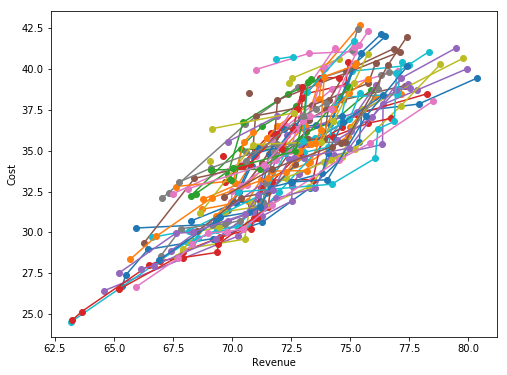

In [53]:
for i,isl in enumerate(archi):
    pop = isl.get_population()
    plot_revenue_cost_frontiers(pop.get_f(), figsize=(8,6)) 
    print('cr={:.2f}\t m={:.3f} \t hypervolume={:.2f}'.format(islands_conf[i][0], islands_conf[i][1], pg.hypervolume(pop).compute(refpoint)))

In [51]:
archi.evolve()

In [60]:
archi

Number of islands: 12
Status: busy

Islands summaries:

	#   Type                    Algo      Prob                                                                      Size  Status  
	------------------------------------------------------------------------------------------------------------------------------
	0   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    idle    
	1   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    idle    
	2   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    idle    
	3   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    idle    
	4   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_revenue_min_cost'>  32    busy    
	5   Multiprocessing island  NSGA-II:  <class '_

cr=0.65	 m=0.010 	 hypervolume=598.36
cr=0.65	 m=0.032 	 hypervolume=605.09
cr=0.65	 m=0.100 	 hypervolume=590.16
cr=0.75	 m=0.010 	 hypervolume=574.37
cr=0.75	 m=0.032 	 hypervolume=600.58
cr=0.75	 m=0.100 	 hypervolume=601.29
cr=0.85	 m=0.010 	 hypervolume=602.45
cr=0.85	 m=0.032 	 hypervolume=591.73
cr=0.85	 m=0.100 	 hypervolume=602.27
cr=0.95	 m=0.010 	 hypervolume=598.16
cr=0.95	 m=0.032 	 hypervolume=607.37
cr=0.95	 m=0.100 	 hypervolume=598.44


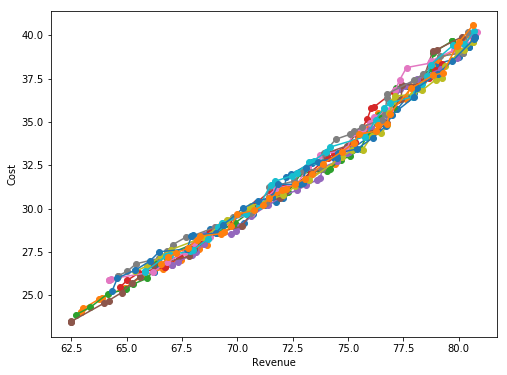

In [61]:
for i,isl in enumerate(archi):
    pop = isl.get_population()
    plot_revenue_cost_frontiers(pop.get_f(), figsize=(8,6)) 
    print('cr={:.2f}\t m={:.3f} \t hypervolume={:.2f}'.format(islands_conf[i][0], islands_conf[i][1], pg.hypervolume(pop).compute(refpoint)))

# Optimization with constraint

## Integer problem

## Optimization with gradient/hessian

## Logging during training

log = algo.extract(pg.nlopt).get_log()
from matplotlib import pyplot as plt 
plt.semilogy([line[0] for line in log], [line[1] for line in log], label = "obj") 
plt.semilogy([line[0] for line in log], [line[3] for line in log], label = "con")
